In [1]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'matplotlib'

In [28]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values
X = ((X / 255.) - .5) * 2

C:\Users\forgedRice\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [29]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=123, stratify=y_temp)

In [30]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):
        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out)  # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out  # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h)  # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)




In [31]:
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                              + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]

In [32]:
def compute_mse_acc_auc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    all_targets = []
    all_probas = []
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

        all_targets.append(onehot_targets)
        all_probas.append(probas)

    # Concatenate all minibatch results
    all_targets = np.vstack(all_targets)
    all_probas = np.vstack(all_probas)

    # Compute macro AUC
    macro_auc = 0
    for i in range(num_labels):
        macro_auc += roc_auc_score(all_targets[:, i], all_probas[:, i])
    macro_auc /= num_labels

    mse = mse / (i + 1)
    acc = correct_pred / num_examples
    return mse, acc, macro_auc

In [37]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, minibatch_size=100, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_auc = []
    epoch_valid_auc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        train_mse, train_acc, train_auc = compute_mse_acc_auc(model, X_train, y_train)
        valid_mse, valid_acc, valid_auc = compute_mse_acc_auc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e + 1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.6f} '
              f'| Train Acc: {train_acc:.6f}% '
              f'| Valid Acc: {valid_acc:.6f}%'
              f'| Train Auc: {train_auc:.6f}'
              f'| Valid Auc: {valid_auc:.6f}')

    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc

In [38]:
num_epochs = 50
minibatch_size = 100
learning_rate = 0.1

model = NeuralNetMLP(num_features=28 * 28,
                     num_hidden=50,
                     num_classes=10)

epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc = train(model, X_train, y_train, X_valid,
                                                                                       y_valid,
                                                                                       minibatch_size=minibatch_size,
                                                                                       num_epochs=num_epochs,
                                                                                       learning_rate=learning_rate)

Epoch: 001/050 | Train MSE: 2.430580 | Train Acc: 69.831633% | Valid Acc: 70.255102%| Train Auc: 0.937289| Valid Auc: 0.937782
Epoch: 002/050 | Train MSE: 1.529534 | Train Acc: 81.959184% | Valid Acc: 82.173469%| Train Auc: 0.962061| Valid Auc: 0.961679
Epoch: 003/050 | Train MSE: 1.166918 | Train Acc: 85.698980% | Valid Acc: 85.571429%| Train Auc: 0.972394| Valid Auc: 0.971803
Epoch: 004/050 | Train MSE: 0.976687 | Train Acc: 87.632653% | Valid Acc: 87.489796%| Train Auc: 0.977853| Valid Auc: 0.977366
Epoch: 005/050 | Train MSE: 0.864973 | Train Acc: 88.793367% | Valid Acc: 88.581633%| Train Auc: 0.981023| Valid Auc: 0.980734
Epoch: 006/050 | Train MSE: 0.788252 | Train Acc: 89.650510% | Valid Acc: 89.469388%| Train Auc: 0.982906| Valid Auc: 0.982724
Epoch: 007/050 | Train MSE: 0.735702 | Train Acc: 90.201531% | Valid Acc: 89.918367%| Train Auc: 0.984134| Valid Auc: 0.984024
Epoch: 008/050 | Train MSE: 0.692328 | Train Acc: 90.591837% | Valid Acc: 90.459184%| Train Auc: 0.985027| Vali

## Evaluating the neural network performance

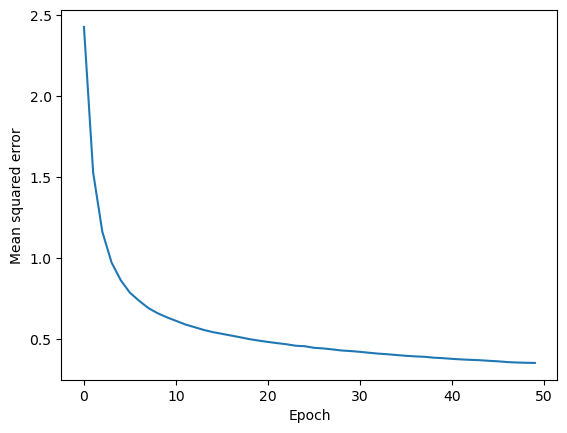

In [22]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

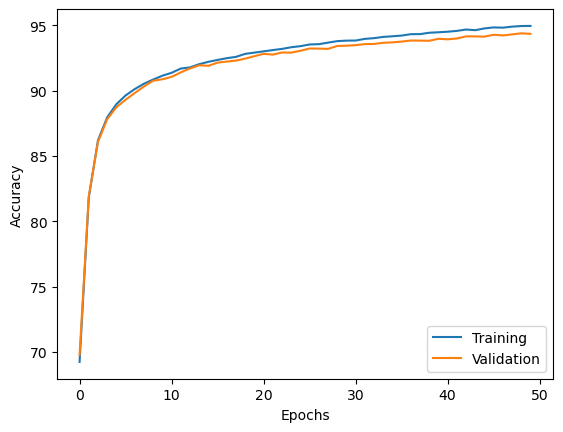

In [23]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

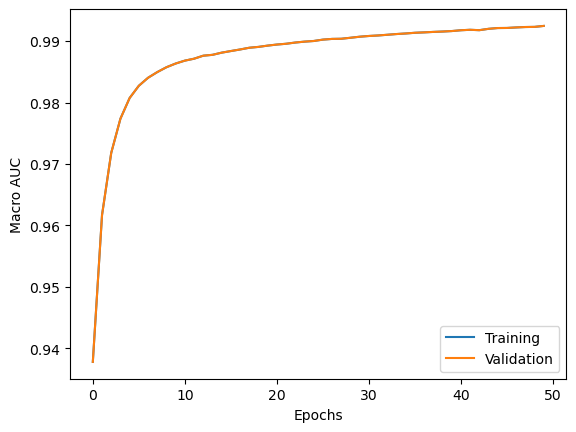

In [40]:
plt.plot(range(len(epoch_train_auc)), epoch_valid_auc,
         label='Training')
plt.plot(range(len(epoch_valid_auc)), epoch_valid_auc,
         label='Validation')
plt.ylabel('Macro AUC')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [39]:
test_mse, test_acc, test_auc = compute_mse_acc_auc(model, X_test, y_test)
print(f'Test MSE: {test_mse:.6f}%')
print(f'Test accuracy: {test_acc * 100:.6f}%')
print(f'Test auc: {test_auc:.6f}%')

Test MSE: 0.214036%
Test accuracy: 94.123810%
Test auc: 0.991689%
